# Experimentos con MLflow

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

from src.stages.data_load import load_data
from src.stages.data_split import split_data
from src.stages.features_transform import features_transform
from src.stages.train_model import train_model
from src.stages.evaluate import evaluate_model

In [3]:
import uuid
import mlflow
import mlflow.sklearn
from mlflow import MlflowClient, active_run
from mlflow.models.signature import infer_signature
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
)
import pandas as pd

In [4]:
MLFLOW_URL = "http://127.0.0.1:8080"
mlflow.set_tracking_uri(MLFLOW_URL)

active_run = mlflow.active_run()

experiment_description = "Experimento para el analisis y prediccion del rendimiento estudiantil usando varios modelos"

experiment_tags = {
    "project_name": "student-performance-analysis",
    "team": "Equipo39-MLOps",
    "mlflow.note.content": experiment_description,
}

## RF + MLflow

Number of features in dataset: 32
Shape of initial dataset (145, 32)
Splitting dataset into train and test-val dataset - 0.7 train proportion
Splitting test-val dataset into test and validation dataset - 0.5 val proportion with respect to test
finish transformations
shapes for train -> (101, 63)
shapes for test -> (22, 63)
shapes for val -> (22, 63)
Training model SGP with {'n_estimators': 200, 'max_depth': 10, 'random_state': 12}
SUPER IMPORTANTES tipo de df_test <class 'pandas.core.frame.DataFrame'>
tipo de X_test <class 'pandas.core.frame.DataFrame'>
tipo de y_test <class 'pandas.core.frame.DataFrame'>
COLUMNAS -> Index(['62'], dtype='object')
Accuracy = 0.4090909090909091
MSE = 5.818181818181818
RMSE = 2.412090756622109
{'accuracy': 0.4090909090909091, 'mse': np.float64(5.818181818181818), 'rmse': np.float64(2.412090756622109)}


/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


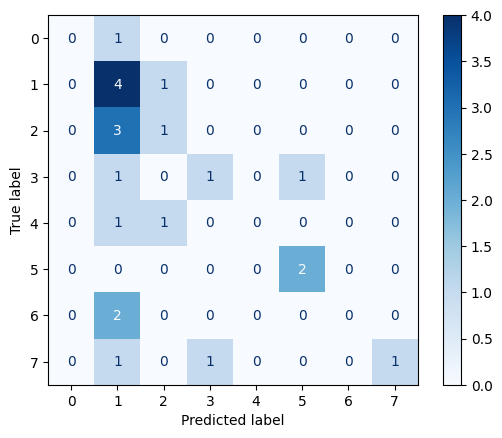

In [18]:
"""
Para esta parte son necesarios _algunos_ de los valores de params.yaml
Definitivamente se puede mejorar en un futuro refactor
"""

config_params = {
    "split_data": {
        "train_proportion": 0.7,
        "val_proportion_wrt_test": 0.5,
        "random_state": 12,
    },
    "train": {
        "model_name": "SGP",
        "algo": "rf",
        "model_path": "",
        "n_estimators": 200,
        "max_depth": 10,
        "random_state": 12
    },
}

data = load_data()
df_train, df_test, df_val = split_data(config_params, data)
df_train, df_test, df_val = features_transform(df_train, df_test, df_val)
model, _ = train_model(config_params, df_train)
metrics, disp = evaluate_model(config_params, df_test, model)

print(metrics)
disp.plot(cmap="Blues")

In [6]:
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1:]
y_test = y_test[str(62)].to_numpy()  # Convert to numpy array

In [7]:
experiment_id_rf = mlflow.create_experiment("Exp_SGP_RF")

In [19]:
with mlflow.start_run(experiment_id=experiment_id_rf) as run:
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Registrando metricas
    mlflow.log_metric("accuracy", accuracy)
    
    mlflow.log_params(model.get_params())
    
    mlflow.set_tag("eval", "validation")
    mlflow.set_tag("sub_experiment", f"{uuid.uuid4()}")
    
    signature = infer_signature(X_test, y_pred)
    
    mlflow.sklearn.log_model(
        sk_model=model,
        input_example=X_test,
        artifact_path="model",
        signature=signature,
    )


/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/metrics/_class

/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
2024/10/30 23:47:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-gnat-448 at: http://127.0.0.1:8080/#/experiments/127197790263528539/runs/0f8de31271544974809b0b8356d8ab34.
2024/10/30 23:47:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/127197790263528539.


In [20]:
print(f"The experiment ID is {experiment_id_rf}")
df = mlflow.search_runs([experiment_id_rf], order_by=["metrics.accuracy DESC"])
df

The experiment ID is 127197790263528539


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.min_impurity_decrease,params.max_samples,params.min_samples_split,...,params.ccp_alpha,params.min_weight_fraction_leaf,params.bootstrap,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.user,tags.sub_experiment,tags.mlflow.runName,tags.eval
0,65569c7611d94e8ab9407b4371995af7,127197790263528539,FINISHED,mlflow-artifacts:/127197790263528539/65569c761...,2024-10-31 05:46:38.929000+00:00,2024-10-31 05:46:41.231000+00:00,0.454545,0.0,None,2,...,0.0,0.0,True,/home/marcela/repos/mna_mlops_equipo39/venv/li...,"[{""run_id"": ""65569c7611d94e8ab9407b4371995af7""...",LOCAL,marcela,d8d28188-066e-4869-9f7d-27a4ccb8d2df,angry-pug-632,validation
1,0f8de31271544974809b0b8356d8ab34,127197790263528539,FINISHED,mlflow-artifacts:/127197790263528539/0f8de3127...,2024-10-31 05:46:59.867000+00:00,2024-10-31 05:47:02.328000+00:00,0.409091,0.0,None,2,...,0.0,0.0,True,/home/marcela/repos/mna_mlops_equipo39/venv/li...,"[{""run_id"": ""0f8de31271544974809b0b8356d8ab34""...",LOCAL,marcela,7e6d3e74-ed6e-4a16-a2d6-7281df7fd3cb,luxuriant-gnat-448,validation
2,554c463fa6bd447ea5094a8f687b0b93,127197790263528539,FINISHED,mlflow-artifacts:/127197790263528539/554c463fa...,2024-10-31 05:45:47.957000+00:00,2024-10-31 05:45:51.374000+00:00,0.363636,0.0,None,2,...,0.0,0.0,True,/home/marcela/repos/mna_mlops_equipo39/venv/li...,"[{""run_id"": ""554c463fa6bd447ea5094a8f687b0b93""...",LOCAL,marcela,bc7478e0-63fe-4aaf-afe1-89ac47bdee61,funny-foal-730,validation


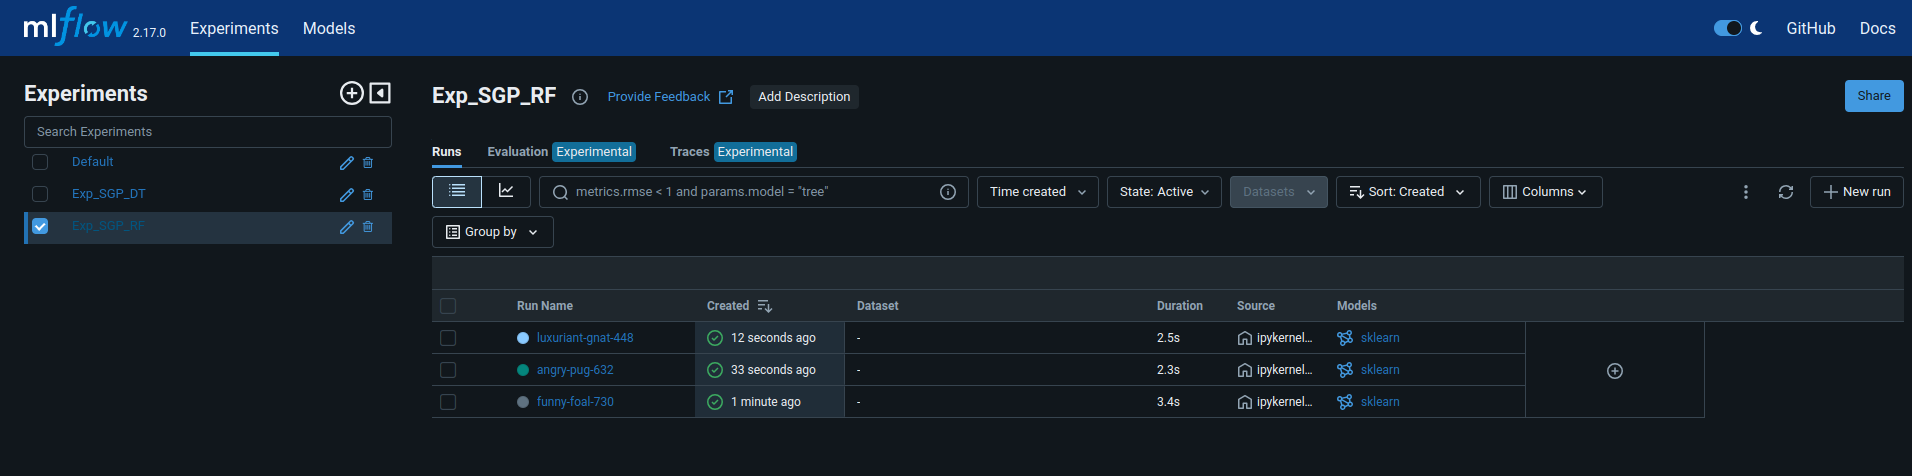

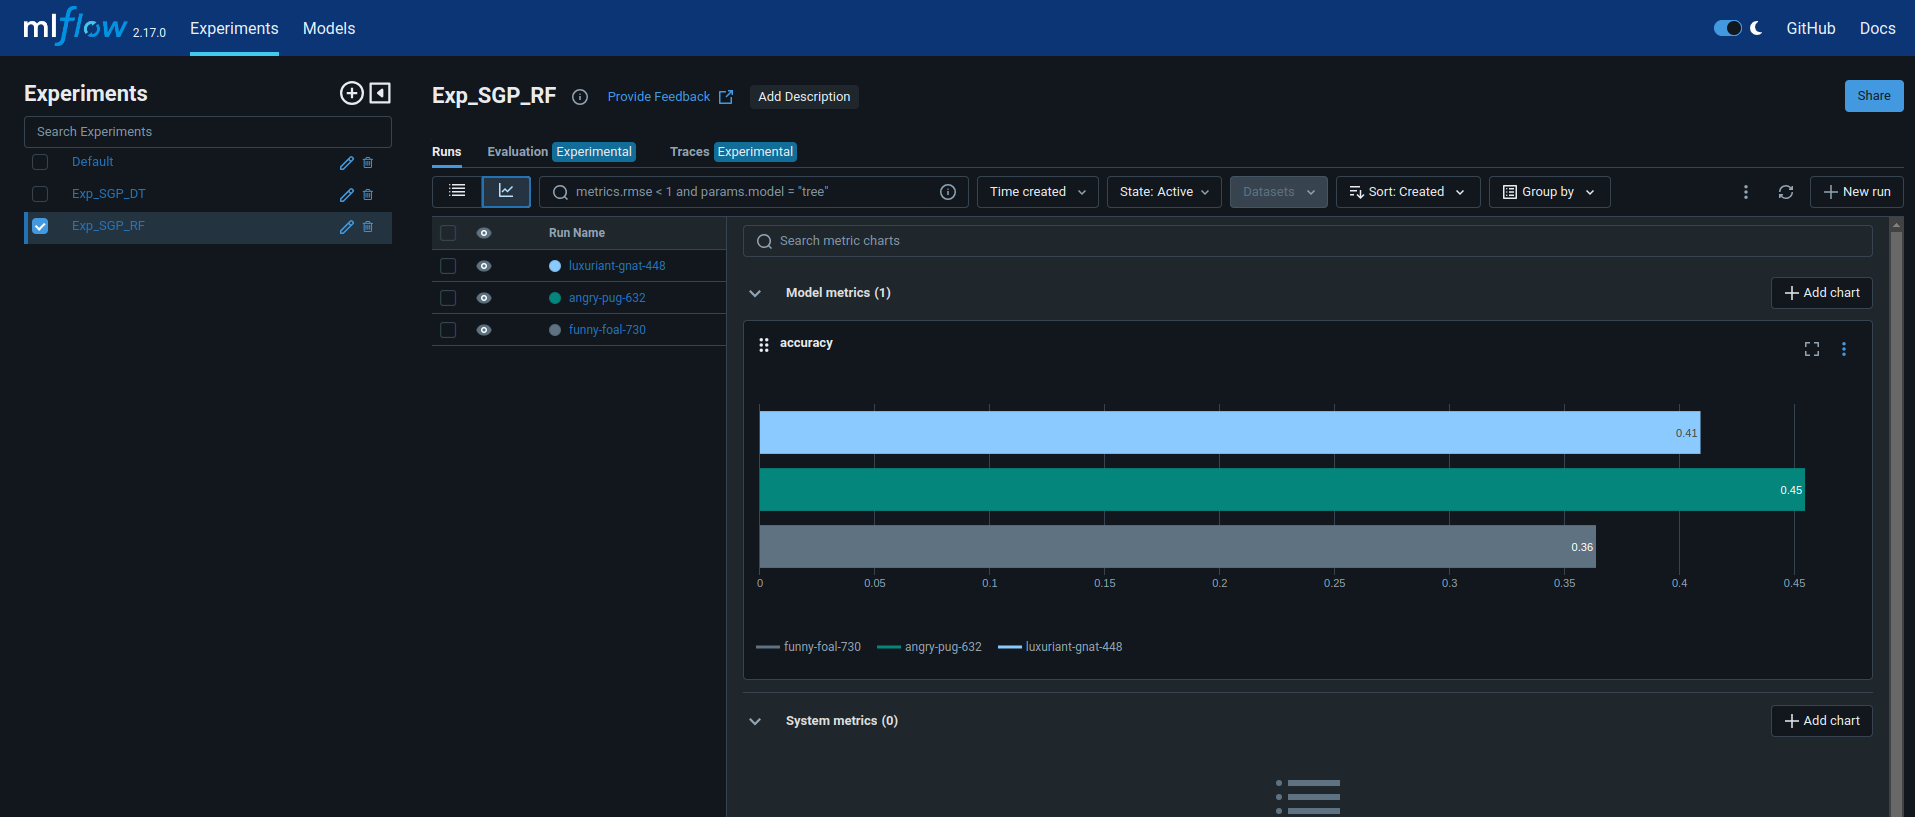

# DT + MLflow

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 7.63 μs
Number of features in dataset: 32
Shape of initial dataset (145, 32)
Splitting dataset into train and test-val dataset - 0.7 train proportion
Splitting test-val dataset into test and validation dataset - 0.5 val proportion with respect to test
finish transformations
shapes for train -> (101, 63)
shapes for test -> (22, 63)
shapes for val -> (22, 63)
Training model SGP with {'max_depth': 5, 'random_state': 12, 'ccp_alpha': 0.0, 'criterion': 'gini', 'max_features': 5, 'max_leaf_nodes': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0}
SUPER IMPORTANTES tipo de df_test <class 'pandas.core.frame.DataFrame'>
tipo de X_test <class 'pandas.core.frame.DataFrame'>
tipo de y_test <class 'pandas.core.frame.DataFrame'>
COLUMNAS -> Index(['62'], dtype='object')
Accuracy = 0.22727272727272727
MSE = 10.227272727272727
RMSE = 3.1980107453341566
{'accuracy': 0.22727272727272727, 'mse': np.float64(10.2272727

/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


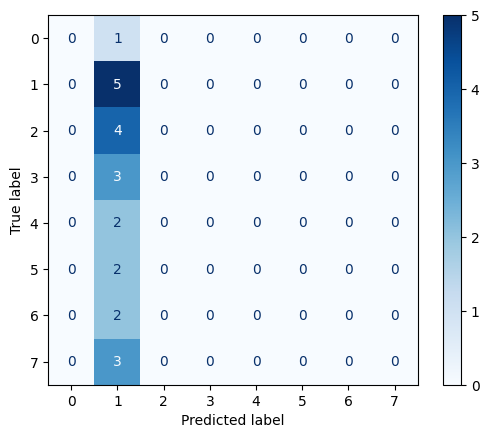

In [21]:
config_params = {
    "split_data": {
        "train_proportion": 0.7,
        "val_proportion_wrt_test": 0.5,
        "random_state": 12,
    },
    "train": {
        "model_name": "SGP",
        "algo": "dt",
        "model_path": "",
        "max_depth": 5,
        "random_state": 12,
        "ccp_alpha": 0.0,
        "criterion": "gini",
        "max_features": 5,
        "max_leaf_nodes": 3,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
        "min_weight_fraction_leaf": 0.0,
    },
}

%time
data = load_data()
df_train, df_test, df_val = split_data(config_params, data)
df_train, df_test, df_val = features_transform(df_train, df_test, df_val)
model, _ = train_model(config_params, df_train)
metrics, disp = evaluate_model(config_params, df_test, model)

print(metrics)
disp.plot(cmap="Blues")

In [11]:
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1:]
y_test = y_test[str(62)].to_numpy()  # Convert to numpy array

In [12]:
experiment_id_dt = mlflow.create_experiment("Exp_SGP_DT")

In [22]:
with mlflow.start_run(experiment_id=experiment_id_dt) as run:
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Registrando metricas
    mlflow.log_metric("accuracy", accuracy)
    
    mlflow.log_params(model.get_params())
    
    mlflow.set_tag("eval", "validation")
    mlflow.set_tag("sub_experiment", f"{uuid.uuid4()}")
    
    signature = infer_signature(X_test, y_pred)
    
    mlflow.sklearn.log_model(
        sk_model=model,
        input_example=X_test,
        artifact_path="model",
        signature=signature,
    )


/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/metrics/_class

/home/marcela/repos/mna_mlops_equipo39/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
2024/10/30 23:48:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-moth-794 at: http://127.0.0.1:8080/#/experiments/375611338391384418/runs/f0fbecfa67f1441daae4adc0746ddac9.
2024/10/30 23:48:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/375611338391384418.


In [23]:
print(f"The experiment ID is {experiment_id_dt}")
df = mlflow.search_runs([experiment_id_dt], order_by=["metrics.accuracy DESC"])
df

The experiment ID is 375611338391384418


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.min_impurity_decrease,params.splitter,params.min_samples_split,...,params.max_features,params.ccp_alpha,params.class_weight,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.user,tags.sub_experiment,tags.mlflow.runName,tags.eval
0,f0fbecfa67f1441daae4adc0746ddac9,375611338391384418,FINISHED,mlflow-artifacts:/375611338391384418/f0fbecfa6...,2024-10-31 05:48:21.385000+00:00,2024-10-31 05:48:23.624000+00:00,0.227273,0.0,best,2,...,5,0.0,None,/home/marcela/repos/mna_mlops_equipo39/venv/li...,"[{""run_id"": ""f0fbecfa67f1441daae4adc0746ddac9""...",LOCAL,marcela,cb0fba79-db2e-4f0a-829a-15dcf8dead66,enchanting-moth-794,validation
1,927c9b7c42984fa3b1fceefe16ad7b08,375611338391384418,FINISHED,mlflow-artifacts:/375611338391384418/927c9b7c4...,2024-10-31 05:45:52.273000+00:00,2024-10-31 05:45:54.440000+00:00,0.227273,0.0,best,3,...,4,0.0,None,/home/marcela/repos/mna_mlops_equipo39/venv/li...,"[{""run_id"": ""927c9b7c42984fa3b1fceefe16ad7b08""...",LOCAL,marcela,1bf261aa-094d-4c55-9850-7e1a525e5c86,intrigued-stork-451,validation


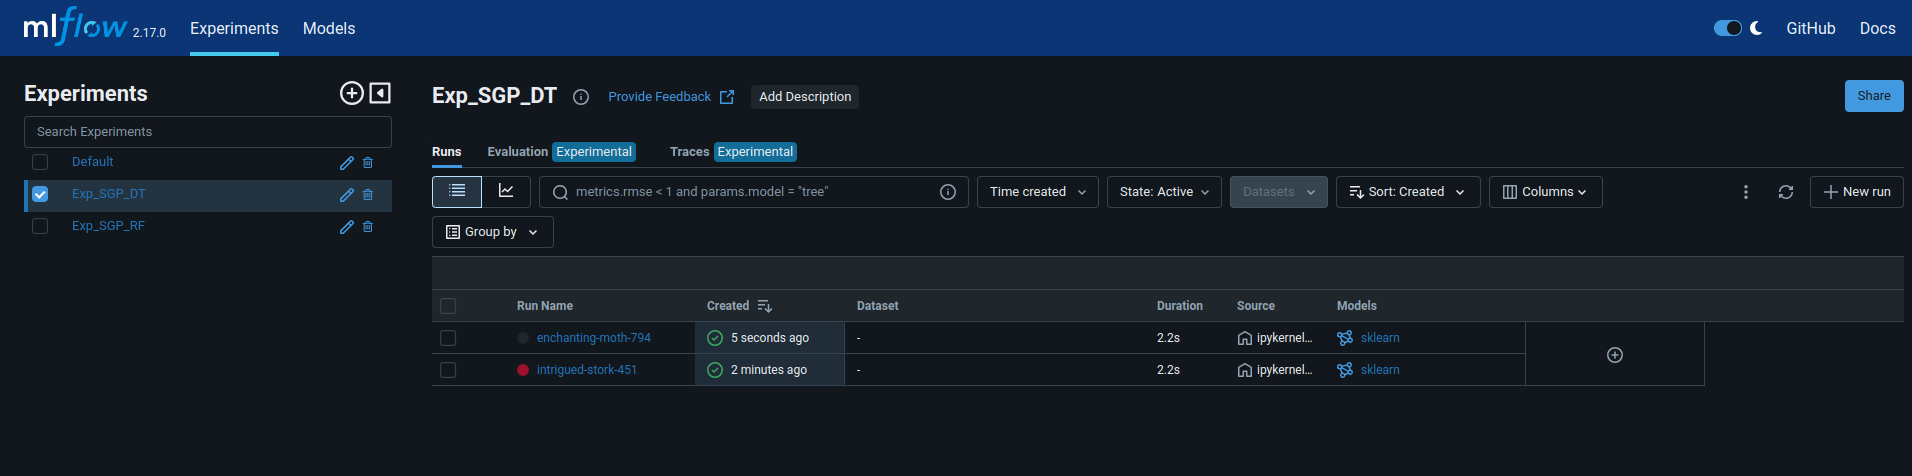

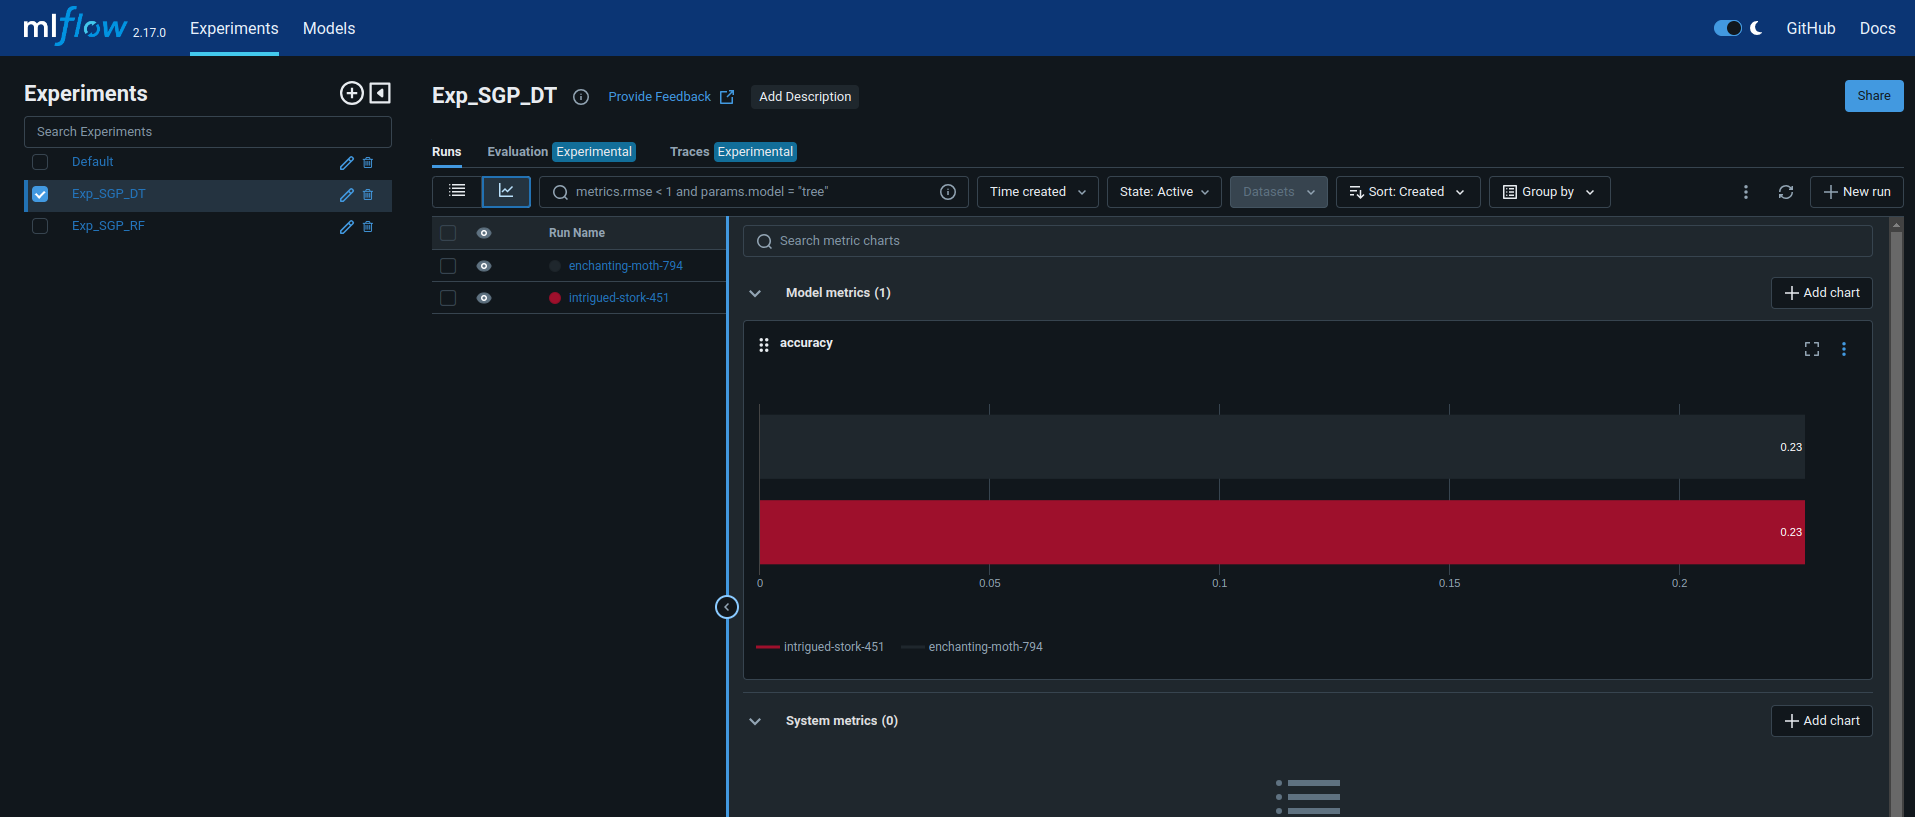

**Algunas notas**

- no es posible repetir el ID de un experimento, y no es necesario darle nombre al experimento. Asi que es importante en este caso mantener el mismo ID para todos los experimentos de RF y otro ID para los experimentos de DT. O si queremos comparar RF vs DT podemos crear otro ID donde podamos compararlos.